# Vector store

In [21]:
#!pip uninstall -y -q gensim
!pip install -q gensim

In [22]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import KeyedVectors
import heapq
from collections import defaultdict, namedtuple
import numpy as np
from numpy import float32 as FLOAT_TYPE



In [23]:
# 1. Parameters
VECTOR_SIZE = 100
WINDOW      = 5
MIN_COUNT   = 5
WORKERS     = 4
MAX_WORDS_IN_BATCH = 500

### CustomLineSentence

In [24]:
import itertools
from gensim import utils

class CustomLineSentence:
    def __init__(self, source):
        self.source = source

    def __iter__(self):
        """Iterate through the lines in the source."""
        with utils.open(self.source, 'rb') as fin:
            for line in itertools.islice(fin, None):
                line = utils.to_unicode(line).split()
                i = 0
                while i < len(line):
                    yield line[i: i + MAX_WORDS_IN_BATCH]
                    i += MAX_WORDS_IN_BATCH


In [25]:
# 2. Load the text8 corpus as a stream of sentences
sentences = CustomLineSentence('data/text8')

In [26]:
print("Type of 'sentences':", type(sentences))
print("What we got from 'sentences':")
for i, s in enumerate(itertools.islice(sentences, 3)):
    print(f"Sentence {i+1}:", s)

    print("Length of sentence:", len(s))

Type of 'sentences': <class '__main__.CustomLineSentence'>
What we got from 'sentences':
Sentence 1: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 

## Custom Doc2Vec Class
Use Gensim's Doc2Vec and TaggedDocument to build and use document vectors.

In [27]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

class CustomDoc2Vec:
    def __init__(self, documents, vector_size=100, window=5, min_count=5, epochs=5, workers=4):
        tagged_docs = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(documents)]
        self.model = Doc2Vec(tagged_docs, vector_size=vector_size, window=window,
                          min_count=min_count, epochs=epochs, workers=workers)

    def infer_vector(self, document):
        return self.model.infer_vector(document)

    def most_similar(self, positive, topn=10):
        return self.model.dv.most_similar(positive, topn=topn)

    def save(self, path):
        self.model.save(path)

    @classmethod
    def load(cls, path):
        m = Doc2Vec.load(path)
        obj = cls([])
        obj.model = m
        return obj

## Document Vector Store
Build document embeddings and search functionality

In [28]:
import numpy as np
from numpy.linalg import norm

class DocumentVectorStore:
    def __init__(self, documents, embedding_model=None):
        """documents: list of token lists or raw text strings"""
        self.raw_documents = documents
        # tokenize if raw strings
        self.tokenized_docs = [doc.split() if isinstance(doc, str) else doc for doc in documents]
        # assign or train word embedding model
        if embedding_model is None:
            from gensim.models import Word2Vec
            self.model = Word2Vec(self.tokenized_docs, vector_size=VECTOR_SIZE, window=WINDOW, min_count=MIN_COUNT, workers=WORKERS)
        else:
            self.model = embedding_model
        # build document embeddings
        self.build_doc_embeddings()

    def build_doc_embeddings(self):
        """Compute document embeddings by averaging word vectors"""
        embeddings = []
        for tokens in self.tokenized_docs:
            vecs = [self.model.wv[word] for word in tokens if word in self.model.wv]
            if vecs:
                doc_vec = np.mean(vecs, axis=0)
            else:
                doc_vec = np.zeros(self.model.vector_size)
            embeddings.append(doc_vec)
        self.doc_embeddings = np.vstack(embeddings)



In [29]:
# Prepare a list of documents (e.g. first 1000 sentences from the text8 stream)
docs = list(itertools.islice(sentences, 500))
# Monkey-patch CustomDoc2Vec.load to avoid retraining on empty docs
def _load_without_rebuild(cls, path):
    m = Doc2Vec.load(path)
    obj = cls.__new__(cls)
    obj.model = m
    return obj

CustomDoc2Vec.load = classmethod(_load_without_rebuild)
# Train our CustomDoc2Vec model
doc2vec_model = CustomDoc2Vec(
    documents=docs,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    epochs=5,
    workers=WORKERS
)

# Save and reload the Doc2Vec model
doc2vec_model.save('custom_doc2vec.model')
loaded_doc2vec = CustomDoc2Vec.load('custom_doc2vec.model')

# Build a DocumentVectorStore using the trained Doc2Vec embeddings
doc_store = DocumentVectorStore(docs, embedding_model=loaded_doc2vec.model)


negative


# We want to use PCA, WHY.

PCA (Principal Component Analysis) is used to reduce the dimensionality of high-dimensional data, such as embeddings, while preserving as much of the original information (variance) as possible.

We are going to give it `n_components=3` to reduce the embeddings to 3 dimensions.

In my test case, we just test the first 100 words.

Also, what I can see when I look at the data is that we have a lot of words that are stopwords. We are going to want to remove them.

(5347, 100)


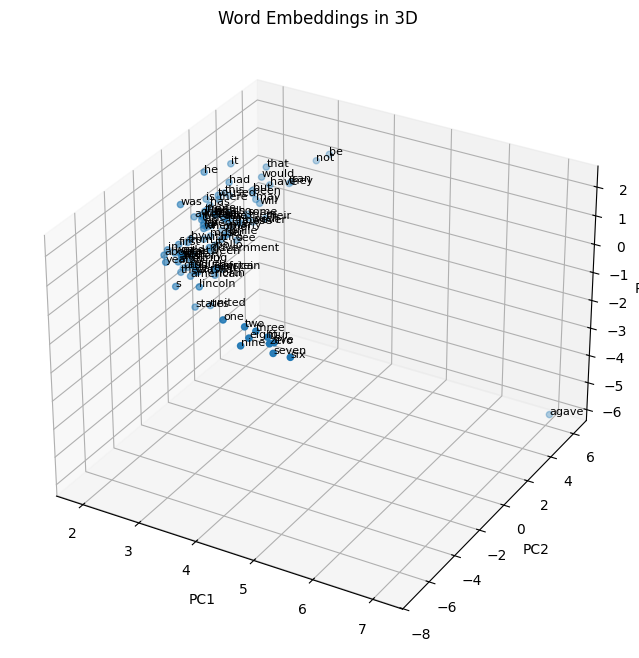

In [30]:
from sklearn.decomposition import PCA

weights = doc2vec_model.model.wv.vectors

print(weights.shape)  # (number of words, vector size)
import matplotlib.pyplot as plt

# Reduce vectors to 3D
pca = PCA(n_components=3)
weights_3d = pca.fit_transform(weights)

# Plot the first 100 words in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weights_3d[:100, 0], weights_3d[:100, 1], weights_3d[:100, 2])

# Annotate points with words
words = list(doc2vec_model.model.wv.index_to_key)
for i in range(100):
    ax.text(weights_3d[i, 0], weights_3d[i, 1], weights_3d[i, 2], words[i], size=8)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Word Embeddings in 3D')
plt.show()
